In [1]:
!pip -q install --upgrade gdown

#https://drive.google.com/file/d/15yqXtwZ5oNi721yeueYWShtJ7t4EoA_U/view?usp=drive_link
!gdown --id 15yqXtwZ5oNi721yeueYWShtJ7t4EoA_U \
       -O Student_Pass_Dataset.csv --quiet

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


## **1. Load and import libraries**

In [2]:
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree

## **2. Load and encode the dataset**

In [3]:
def encode_df(df):
# Encode categorical features and target
# We map 'Yes'/'No' in a way that ensures 'Yes' (0) goes to the left child, 'No' (1) to the right
    df2 = df.copy()
    bin_map = {'Có': 0, 'Không': 1}
    df2['Chứng_chỉ_Ielts']   = df2['Chứng_chỉ_Ielts'].map(bin_map)
    df2['Cộng_Điểm_Dân_Tộc'] = df2['Cộng_Điểm_Dân_Tộc'].map(bin_map)
    df2['Đậu_ĐH']            = df2['Đậu_ĐH'].map({'Có': 1, 'Không': 0})
    return df2

# Load the dataset
df = pd.read_csv(
    'Student_Pass_Dataset.csv',
    names=['Điểm_Tốt_Nghiệp', 'Chứng_chỉ_Ielts', 'Cộng_Điểm_Dân_Tộc', 'Đậu_ĐH'],
    header=0
)
print("Original dataset:")
display(df)

# Encode
df_encoded = encode_df(df)
print("Encoded dataset:")
display(df_encoded)

Original dataset:


,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_Điểm_Dân_Tộc,Đậu_ĐH
0,12.0,Không,Không,Không
1,14.5,Không,Có,Không
2,16.0,Không,Không,Không
3,18.0,Không,Có,Không
4,20.0,Có,Không,Có
5,22.0,Không,Không,Không
6,24.0,Có,Có,Có
7,26.0,Không,Không,Có


Encoded dataset:


,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_Điểm_Dân_Tộc,Đậu_ĐH
0,12.0,1,1,0
1,14.5,1,0,0
2,16.0,1,1,0
3,18.0,1,0,0
4,20.0,0,1,1
5,22.0,1,1,0
6,24.0,0,0,1
7,26.0,1,1,1


## **3. Compute root entropy of the target**

In [4]:
def entropy(probs):
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

root_probs   = df_encoded['Đậu_ĐH'].value_counts(normalize=True).sort_index().values
root_entropy = entropy(root_probs)
print(f"Root entropy của Đậu_ĐH = {root_entropy:.4f}")

Root entropy của Đậu_ĐH = 0.9544


## **4. Compute Information Gain for each feature**

In [5]:
print("\nInformation Gain cho từng thuộc tính:")
features = ['Chứng_chỉ_Ielts', 'Điểm_Tốt_Nghiệp', 'Cộng_Điểm_Dân_Tộc']
for feat in features:
    print(f"\n- Thuộc tính: {feat}")
    vals = sorted(df_encoded[feat].unique())
    thresholds = [0.5] if feat in ['Chứng_chỉ_Ielts','Cộng_Điểm_Dân_Tộc'] \
                 else [(vals[i]+vals[i+1])/2 for i in range(len(vals)-1)]
    best_gain, best_thr = -1, None
    for thr in thresholds:
        left  = df_encoded[df_encoded[feat] <= thr]['Đậu_ĐH']
        right = df_encoded[df_encoded[feat] >  thr]['Đậu_ĐH']
        pL, pR = left.value_counts(normalize=True).values, right.value_counts(normalize=True).values
        eL, eR = entropy(pL), entropy(pR)
        wE     = (len(left)/len(df_encoded))*eL + (len(right)/len(df_encoded))*eR
        ig     = root_entropy - wE
        print(f"    Ngưỡng ≤ {thr}: Ent(L)={eL:.4f}, Ent(R)={eR:.4f}, Ent trọng số={wE:.4f}, IG={ig:.4f}")
        if ig > best_gain:
            best_gain, best_thr = ig, thr
    print(f"  → Chọn ngưỡng {best_thr} với IG = {best_gain:.4f}")


Information Gain cho từng thuộc tính:

- Thuộc tính: Chứng_chỉ_Ielts
    Ngưỡng ≤ 0.5: Ent(L)=-0.0000, Ent(R)=0.6500, Ent trọng số=0.4875, IG=0.4669
  → Chọn ngưỡng 0.5 với IG = 0.4669

- Thuộc tính: Điểm_Tốt_Nghiệp
    Ngưỡng ≤ 13.25: Ent(L)=-0.0000, Ent(R)=0.9852, Ent trọng số=0.8621, IG=0.0924
    Ngưỡng ≤ 15.25: Ent(L)=-0.0000, Ent(R)=1.0000, Ent trọng số=0.7500, IG=0.2044
    Ngưỡng ≤ 17.0: Ent(L)=-0.0000, Ent(R)=0.9710, Ent trọng số=0.6068, IG=0.3476
    Ngưỡng ≤ 19.0: Ent(L)=-0.0000, Ent(R)=0.8113, Ent trọng số=0.4056, IG=0.5488
    Ngưỡng ≤ 21.0: Ent(L)=0.7219, Ent(R)=0.9183, Ent trọng số=0.7956, IG=0.1589
    Ngưỡng ≤ 23.0: Ent(L)=0.6500, Ent(R)=-0.0000, Ent trọng số=0.4875, IG=0.4669
    Ngưỡng ≤ 25.0: Ent(L)=0.8631, Ent(R)=-0.0000, Ent trọng số=0.7552, IG=0.1992
  → Chọn ngưỡng 19.0 với IG = 0.5488

- Thuộc tính: Cộng_Điểm_Dân_Tộc
    Ngưỡng ≤ 0.5: Ent(L)=0.9183, Ent(R)=0.9710, Ent trọng số=0.9512, IG=0.0032
  → Chọn ngưỡng 0.5 với IG = 0.0032


## **5. Train a full-depth tree and visualize**

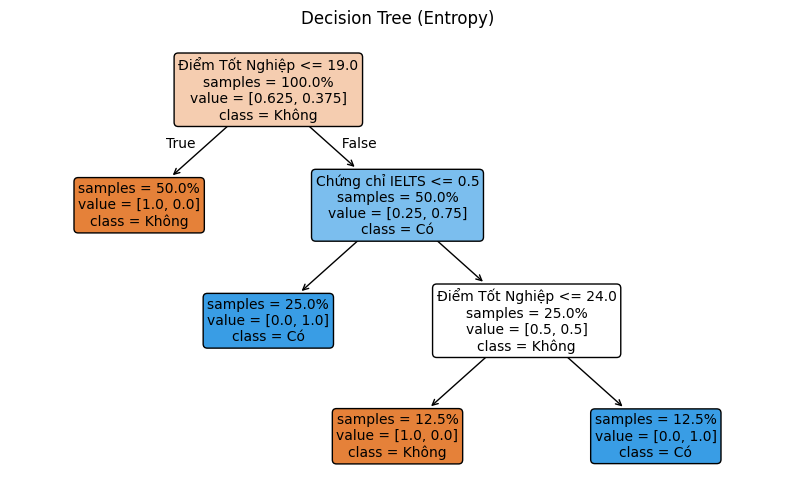

In [6]:
X   = df_encoded[features]
y   = df_encoded['Đậu_ĐH']
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X, y)

plt.figure(figsize=(10,6))
plot_tree(
    clf,
    feature_names=['Chứng chỉ IELTS','Điểm Tốt Nghiệp','Cộng Điểm Dân Tộc'],
    class_names=['Không','Có'],
    filled=True, rounded=True, proportion=True, impurity=False, fontsize=10
)
plt.title('Decision Tree (Entropy)')
plt.show()

##**6. Test**

In [7]:
_mapping = {'Có': 0, 'Không': 1}

def encode_input(record):
    return [
        _mapping[record['Chứng_chỉ_Ielts']],
        record['Điểm_Tốt_Nghiệp'],
        _mapping[record['Cộng_Điểm_Dân_Tộc']]
    ]

def predict_pass(record):
    x_list = encode_input(record)
    df_new = pd.DataFrame([x_list], columns=features)
    pred   = clf.predict(df_new)[0]
    return 'Có' if pred == 1 else 'Không'

new_student = {
    'Điểm_Tốt_Nghiệp': 2.0,
    'Chứng_chỉ_Ielts': 'Có',
    'Cộng_Điểm_Dân_Tộc': 'Không'
}
print("Kết quả dự đoán:", predict_pass(new_student))

Kết quả dự đoán: Không


## **7. Demo with Gradio**

In [8]:
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def predict_and_plot(diem, ielts, dan_toc):
    try:
        record = {
            'Điểm_Tốt_Nghiệp': float(diem),
            'Chứng_chỉ_Ielts': ielts,
            'Cộng_Điểm_Dân_Tộc': dan_toc
        }
        result = predict_pass(record)
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_tree(
            clf,
            feature_names=['Chứng chỉ IELTS','Điểm Tốt Nghiệp','Cộng Điểm Dân Tộc'],
            class_names=['Không','Có'],
            filled=True, rounded=True, proportion=True, impurity=False,
            fontsize=8, ax=ax
        )
        ax.set_title('Decision Tree (Entropy)')
        plt.tight_layout()
        return result, fig
    except Exception as e:
        return f"Lỗi nhập liệu: {e}", None

iface = gr.Interface(
    fn=predict_and_plot,
    inputs=[
        gr.Number(
            label="Điểm Tốt Nghiệp",
            value=None,
            placeholder="Ví dụ: 17.0"
        ),
        gr.Radio(
            choices=['Có', 'Không'],
            label="Chứng chỉ IELTS",
            value='Có'
        ),
        gr.Radio(
            choices=['Có', 'Không'],
            label="Cộng Điểm Dân Tộc",
            value='Không'
        ),
    ],
    outputs=[
        gr.Textbox(label="Dự đoán Đậu Đại Học"),
        gr.Plot(label="Decision Tree")
    ],
    title="Demo Student Pass Predictor",
    description="""
**Hướng dẫn nhập liệu**
- **Điểm Tốt Nghiệp**: Nhập số điểm tốt nghiệp (float).
- **Chứng chỉ IELTS**: Chọn `Có` nếu bạn đã có chứng chỉ IELTS, ngược lại chọn `Không`.
- **Cộng Điểm Dân Tộc**: Chọn `Có` nếu bạn được cộng điểm dân tộc, ngược lại chọn `Không`.
Bấm **Run** để xem kết quả dự đoán và cây quyết định.
"""
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5ae95432d3c8fd325d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
